In [531]:
import corv
import pyphot
from pyphot import unit
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pygaia.errors.astrometric import parallax_uncertainty
import lightning as pl
import scipy.stats as ss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [532]:
model = corv.models.Spectrum('1d_da_nlte')
library = pyphot.get_library()

def forward(teff, distance, radius, bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']):
    pc_to_m = 3.0856775814671916e16
    rsun_to_m = 6.957e8
    bands = [library[band] for band in bands]
    wavl, interp = model.wavl, model.model_spec
    flux = interp((teff, 8)) * ((radius*rsun_to_m) / (distance * pc_to_m))**2
    band_flux = np.array([band.get_flux(wavl * unit['AA'], flux * unit['erg/s/cm**2/AA'], axis=1).value for band in bands])
    return band_flux

def sim_forward(teff, distance, radius, bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']):
    snr = np.random.uniform(300, 400)
    band_flux = forward(teff, distance, radius, bands)
    band_flux_noisy = np.random.normal(band_flux, band_flux/snr)

    gmag = -2.5 * np.log10(band_flux_noisy[0] / 2.4943e-09)
    plx_unc = parallax_uncertainty(gmag, release='dr3') * 1e-6
    plx = np.random.normal(loc = -0.000014 + (1 / distance), scale = plx_unc, size=(1))
    plx_data = np.concatenate([plx, np.array([plx_unc])])

    obs = np.concatenate([band_flux_noisy, band_flux_noisy/snr])
    return np.concatenate([plx_data, obs])

In [533]:
bands = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 'SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i', 'SDSS_z']
wavl = np.array([library[band].lpivot.to('AA').value for band in bands])

theta = np.array([10000, 100, 0.02])
data = sim_forward(*theta)

In [534]:
data

array([1.02357296e-02, 2.68655668e-04, 6.65447119e-17, 1.03527262e-16,
       3.61357854e-17, 1.58747906e-16, 1.27152231e-16, 6.94802342e-17,
       4.17122099e-17, 2.44718734e-17, 2.11617432e-19, 3.29224857e-19,
       1.14914647e-19, 5.04830860e-19, 4.04354122e-19, 2.20952624e-19,
       1.32648117e-19, 7.78224872e-20])

In [535]:
theta_samples = np.load('data/wdparams_theta.npy')
x_samples = np.load('data/wdparams_x.npy')

In [536]:
# Convert to torch tensors
theta_samples = torch.tensor(theta_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

# Normalize the data
x_mean = x_samples.mean(dim=0)
x_std = x_samples.std(dim=0)
x_samples = (x_samples - x_mean) / x_std

theta_mean = theta_samples.mean(dim=0)
theta_std = theta_samples.std(dim=0)
theta_samples = (theta_samples - theta_mean) / theta_std

In [537]:
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_samples, theta_samples)

dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

In [538]:
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    """Create an MLP from the configuration."""
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)

In [539]:
def get_flow(d_in=2, d_hidden=32, d_context=16, n_layers=4):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """
    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

# Instantiate flow
flow = get_flow()

# Make sure sampling and log-prob calculation makes sense
samples, log_prob = flow.sample_and_log_prob(num_samples=100, context=torch.randn(2, 16))
-log_prob[0]

tensor([ 4.4011,  6.0815,  7.3929,  4.7498,  5.4776,  5.4342,  8.3729,  4.2657,
         5.5075,  4.8850,  5.1368,  4.6958, 10.1272,  5.6320,  4.5572,  9.6612,
         4.3191,  4.7034,  7.0259,  4.8684,  4.5701,  6.6495,  5.4175,  4.5372,
         5.7163,  5.8074,  4.5168,  6.2378,  4.6474,  5.3631,  4.9059,  6.8138,
         5.6715,  7.4841,  4.9223,  4.7750,  4.3819,  5.3928,  4.6456,  4.8493,
         5.7530,  5.1606,  6.2276,  4.3525,  5.8932,  4.5460,  7.9270,  4.3353,
         5.9612,  6.2757,  4.2584,  4.2580,  4.2507,  4.4894,  4.3637,  4.6333,
         4.2999,  7.0702,  4.6815,  4.5610,  4.5417,  4.7290,  5.2863,  5.4418,
         4.4018,  4.4634,  4.2602,  4.2982,  4.8673,  4.5128, 11.2834,  4.7663,
         4.5700,  4.6823,  5.0551,  4.9327,  4.6028,  5.1573,  4.7507,  5.6117,
         4.2989,  6.3357,  4.3556,  4.4369,  4.6389,  8.3202,  4.5011,  4.3312,
         4.2555,  4.5455,  5.0900,  4.4288,  5.1532,  6.1299,  4.4132,  4.4420,
         5.6807,  4.9302,  5.7718,  4.46

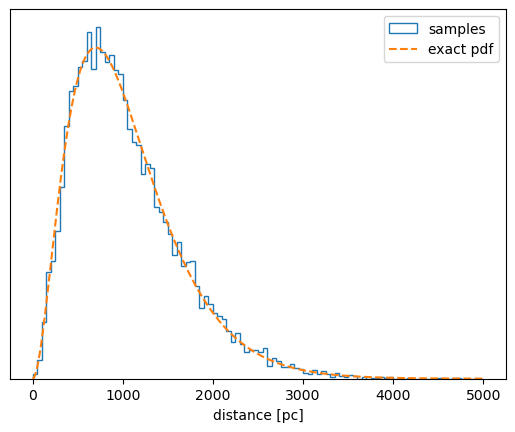

In [540]:
from torch.distributions import Chi2, transforms, transformed_distribution

L = np.array([350])
prior = transformed_distribution.TransformedDistribution(
        Chi2(6), transforms.AffineTransform(loc=0, scale=0.5 * L[0])
    )
r = prior.sample((10_000,))


x = np.linspace(0, 5000, 500)
plt.hist(r, 100, range=(0, 5000), density=True, histtype="step", label="samples")
plt.plot(x, 0.5 * x**2 * np.exp(-x / L[0]) / L[0]**3, "--", label="exact pdf")
plt.xlabel("distance [pc]")
plt.yticks([])
plt.legend();

In [541]:
theta_mean, theta_std = theta_mean.clone().detach().numpy(), theta_std.clone().detach().numpy()
x_mean, x_std = x_mean.clone().detach().numpy(), x_std.clone().detach().numpy()

In [542]:
from torch.distributions import Chi2, transformed_distribution

class NeuralPosteriorEstimator(pl.LightningModule):
    """ Simple neural posterior estimator class using a normalizing flow as the posterior density estimator.
    """
    def __init__(self, featurizer, data, d_context=8):
        super().__init__()
        self.d_in = 3
        self.featurizer = featurizer
        self.flow = get_flow(d_in=self.d_in, d_hidden=32, d_context=d_context, n_layers=4)

        self.data = {name: nn.Parameter(torch.tensor(data[name], requires_grad=False, dtype=torch.float32, device=self.device)) for name in data}
        for name in self.data:
            self.register_parameter('data_' + name, self.data[name])

    def forward(self, x):
        return self.featurizer(x)
    
    def loss(self, x, theta):
        def log_distance(distance, plx):
            plx, e_plx = plx[:,0], plx[:,1]
            likelihood = torch.distributions.Normal(1/distance, e_plx).log_prob(plx)
            prior_prob = transformed_distribution.TransformedDistribution(
                Chi2(6), transforms.AffineTransform(loc=0, scale=0.5 * float(self.data_L.data))
            ).log_prob(distance)
            return prior_prob + likelihood

        actual_theta = theta * self.data_theta_std.data + self.data_theta_mean.data
        actual_x = x * self.data_x_std.data + self.data_x_mean.data
        plx, distance = actual_x[:,:2],  actual_theta[:,1]
    
        context = self(x[:,2:])
        return -(self.flow.log_prob(inputs=theta, context=context) + log_distance(distance, plx))

    def training_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, theta = batch
        loss = self.loss(x, theta).mean()
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)
    

In [543]:
data = {'x_mean': x_mean, 'x_std': x_std, 'theta_mean': theta_mean, 'theta_std': theta_std, 'L': L} 
d_context=8

npe = NeuralPosteriorEstimator(build_mlp(input_dim=x_samples.shape[1]-2, hidden_dim=16, output_dim=d_context, layers=2), data, d_context=d_context)
(npe.loss(x_samples[:64], theta_samples[:64]) / x_samples.shape[1]).sum()

tensor(37.0843, grad_fn=<SumBackward0>)

In [545]:
print(f"npe.device: {npe.device}")
trainer = pl.Trainer(max_epochs=20, enable_checkpointing=False)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


npe.device: cpu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode
---------------------------------------------------
0 | featurizer   | Sequential | 952    | eval
1 | flow         | Flow       | 21.7 K | eval
  | other params | n/a        | 43     | n/a 
---------------------------------------------------
22.7 K    Trainable params
0         Non-trainable params
22.7 K    Total params
0.091     Total estimated model params size (MB)
0         Modules in train mode
87        Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [519]:
import corner

theta_test = np.array([7000, 200, 0.01])
x_test = sim_forward(*theta_test, bands)
x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std

context = npe.featurizer(x_test_norm[2:]).unsqueeze(0)
samples_test = (npe.flow.sample(num_samples=10000, context=context) * theta_std + theta_mean).detach().numpy()
corner.corner(samples_test[0], labels=["teff", "distance", "radius"], truths=theta_test, discard = 5000);

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

## Test With Real Data

In [303]:
import pyvo

In [304]:
def get_ngf21():
    tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
    QUERY = f"""select top 1000 *
            from \"J/MNRAS/508/3877/maincat\" as ngf
            join \"J/A+A/674/A33/gspc-wd\" as gspc 
            on ngf.GaiaEDR3 = gspc.GaiaDR3
            where ngf.e_TeffH is not NULL and ngf.e_loggH is not NULL and ngf.e_TeffHe is not NULL and ngf.e_loggHe is not NULL
            and RAND() < 0.01"""
    return tap_service.search(QUERY).to_table().to_pandas()

ngf21 = get_ngf21()

Epoch 6:   9%|▉         | 31/352 [135:35:37<1404:03:04,  0.00it/s, v_num=65, train_loss=inf.0, val_loss=inf.0]
